In [1]:
%load_ext autoreload
%autoreload 2

In [74]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from numpy import random
from sklearn.model_selection import GridSearchCV
from model.forest import train_forest
from sklearn.metrics import f1_score

from model.gradient_boosting import train_gradient_boosting
from utils import show_cluster, plot_clustermap, plot_legend, get_importances

random.mtrand._rand.seed(774)
warnings.filterwarnings("ignore")

In [23]:
data = pd.read_csv("../data/genes_extra_data.csv", delimiter=",", decimal='.')
data = data[data["race"].isin(["White", "Black Or African American", "Black"])]
data["is_white"] = data["race"] == "White"
data.drop(columns=["sample_id", "race"], inplace=True)

white_people_data = data[data["is_white"] == True].drop(columns=["is_white"])
black_people_data = data[data["is_white"] == False].drop(columns=["is_white"])

Acc: 0.738283775048481, F1 Score: 0.8413035276362951


/Users/igormandello/projects/lla-analysis/.venv/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


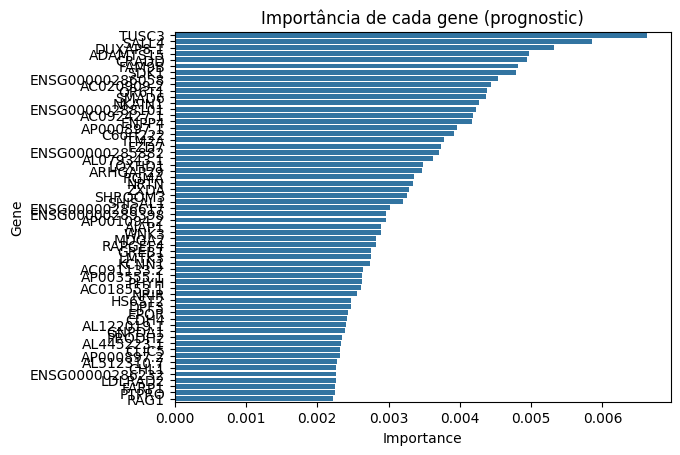

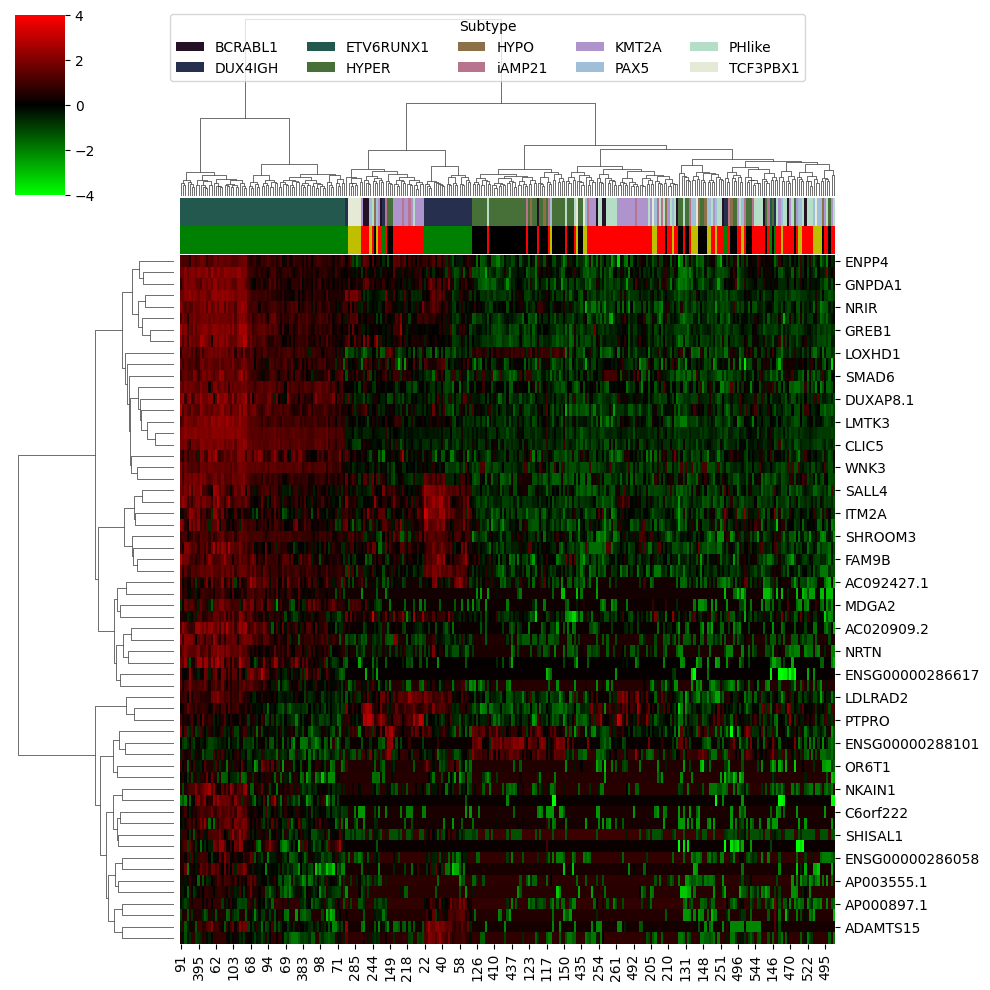

In [24]:
show_cluster(white_people_data, "prognostic", top=60)

/Users/igormandello/projects/lla-analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/igormandello/projects/lla-analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/igormandello/projects/lla-analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Acc: 0.5757142857142857, F1 Score: 0.7397849071181953


/Users/igormandello/projects/lla-analysis/.venv/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


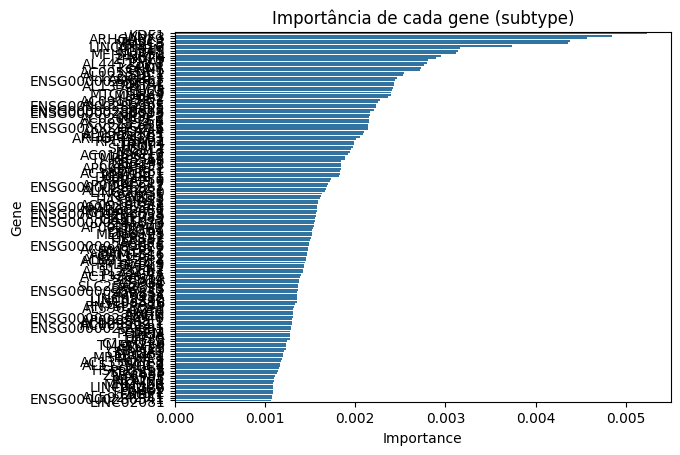

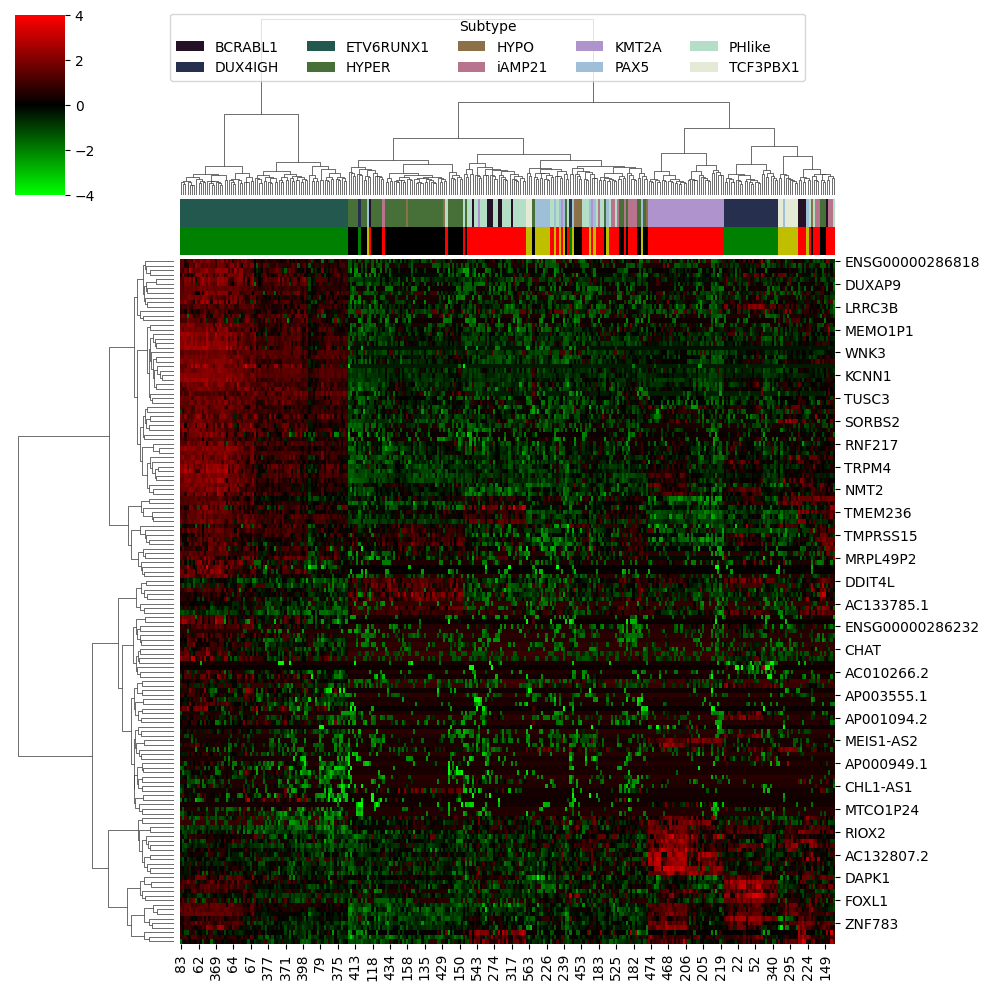

In [26]:
show_cluster(white_people_data, "subtype", top=150)

In [27]:
importances_by_subtype = {}
forest_params = {
  "n_estimators": 64,
  "max_depth": 2,
  "class_weight": "balanced"
}
f1s_by_subtype = {}
tops = list(range(5, 60, 5))

genes = set()
for subtype in data["subtype"].unique():
  targeted_data = white_people_data.copy()
  targeted_data["subtype_target"] = targeted_data["subtype"] == subtype

  response = train_forest("subtype_target", data=targeted_data, **forest_params)
  print(f"\n======== Subtype {subtype} - F1 Score {response.f1} - ACC {response.acc} - Recall {response.recall} ========")

  f1s_by_subtype[subtype] = []
  targets = []
  for top in tops:
    importances_target = get_importances(response.model.feature_importances_, response.feature_names, top=top)
    current_important_data = targeted_data.copy()[["subtype_target", *importances_target.index]]

    search_params = None
    if subtype in ["iAMP21", "BCRABL1"]:
      search_params = {"n_estimators": (2, 4, 8, 16, 32, 64), "max_depth": (2, 4, 16, 64)}

    subset_response = train_forest("subtype_target", data=current_important_data, grid_search_scoring="recall", grid_search_params=search_params, **forest_params)
    f1s_by_subtype[subtype].append(subset_response.f1)
    targets.append(importances_target)

  print(f"F1s for {subtype}: {str(f1s_by_subtype[subtype])}")
  # enumerated_f1s = list(enumerate(f1s_by_subtype[subtype]))
  # i, score = next((x for x in enumerated_f1s if x[1] >= 0.8)) or enumerated_f1s[-1]
  i, max_f1 = max(enumerate(f1s_by_subtype[subtype]), key=lambda x: x[1])
  # i, score = next((x for x in enumerated_f1s if max_score - x[1] <= 0.01))
  print(f"Chosen top: {tops[i]}, {i=} {max_f1=}")

  importances_target = targets[i]
  importances_by_subtype[subtype] = importances_target
  genes |= set(importances_target.index)

  cluster_data = targeted_data.drop(axis=1, labels=["prognostic", "subtype", "subtype_target"])[importances_target.index].transpose()
  col_colors = [targeted_data["subtype_target"].map({ True: "yellow", False: "black" })]

  # g = plot_clustermap(cluster_data, col_colors)
  # g.figure.suptitle(subtype, y=1)
  # plt.show()

  # print(importances_target.to_string())

important_genes = list(genes)

/Users/igormandello/projects/lla-analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/igormandello/projects/lla-analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/igormandello/projects/lla-analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf


======== Subtype BCRABL1 - F1 Score 0.0 - ACC 0.5 - Recall 0.0 ========
Best params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 32, 'n_jobs': -1, 'oob_score': False, 'random_state': 774, 'verbose': 0, 'warm_start': False}
Best params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 32, 'n_jobs': -1, 'oob_score': False, 'random_state': 774, 'verbose': 0, 'warm_start': False}
Best params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'bal

/Users/igormandello/projects/lla-analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/igormandello/projects/lla-analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/igormandello/projects/lla-analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf


======== Subtype HYPO - F1 Score 0.0 - ACC 0.5 - Recall 0.0 ========


/Users/igormandello/projects/lla-analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/igormandello/projects/lla-analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/igormandello/projects/lla-analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

F1s for HYPO: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Chosen top: 5, i=0 max_f1=0.0


/Users/igormandello/projects/lla-analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/igormandello/projects/lla-analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/igormandello/projects/lla-analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf


======== Subtype iAMP21 - F1 Score 0.0 - ACC 0.5 - Recall 0.0 ========
Best params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 4, 'n_jobs': -1, 'oob_score': False, 'random_state': 774, 'verbose': 0, 'warm_start': False}
Best params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 4, 'n_jobs': -1, 'oob_score': False, 'random_state': 774, 'verbose': 0, 'warm_start': False}
Best params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanc

/Users/igormandello/projects/lla-analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/igormandello/projects/lla-analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/igormandello/projects/lla-analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Best params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 32, 'n_jobs': -1, 'oob_score': False, 'random_state': 774, 'verbose': 0, 'warm_start': False}
Best params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 64, 'n_jobs': -1, 'oob_score': False, 'random_state': 774, 'verbose': 0, 'warm_start': False}
Best params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'max

/Users/igormandello/projects/lla-analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/igormandello/projects/lla-analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/igormandello/projects/lla-analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf


======== Subtype KMT2A - F1 Score 0.9473684210526315 - ACC 0.95 - Recall 0.9 ========
F1s for KMT2A: [0.8571428571428571, 0.8571428571428571, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 1.0, 1.0, 0.9473684210526315]
Chosen top: 45, i=8 max_f1=1.0

======== Subtype PAX5 - F1 Score 0.3333333333333333 - ACC 0.6 - Recall 0.2 ========
F1s for PAX5: [0.36363636363636365, 0.4444444444444444, 0.4, 0.2857142857142857, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.5714285714285714, 0.3333333333333333, 0.5714285714285714]
Chosen top: 45, i=8 max_f1=0.5714285714285714

======== Subtype PHlike - F1 Score 0.5714285714285714 - ACC 0.714759535655058 - Recall 0.4444444444444444 ========
F1s for PHlike: [0.43478260869565216, 0.5882352941176471, 0.5, 0.5333333333333333, 0.5882352941176471, 0.7777777777777778, 0.4444444444444444, 0.5263157894736842, 0.6, 0.5263157894736842, 0.5]
Chosen top: 30,

<Axes: title={'center': 'Importância de cada gene por subtipo One-vs-All'}, xlabel='Importance', ylabel='Gene'>

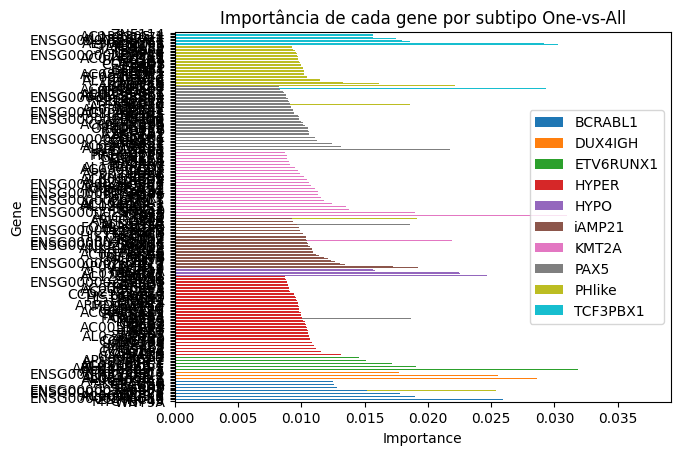

In [28]:
one_vs_all_df = pd.concat(importances_by_subtype.values(), axis=1).fillna(0)
one_vs_all_df.columns = importances_by_subtype.keys()
one_vs_all_df.plot(kind="barh", stacked=True, xlabel='Importance', ylabel='Gene', title="Importância de cada gene por subtipo One-vs-All")

/Users/igormandello/projects/lla-analysis/.venv/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


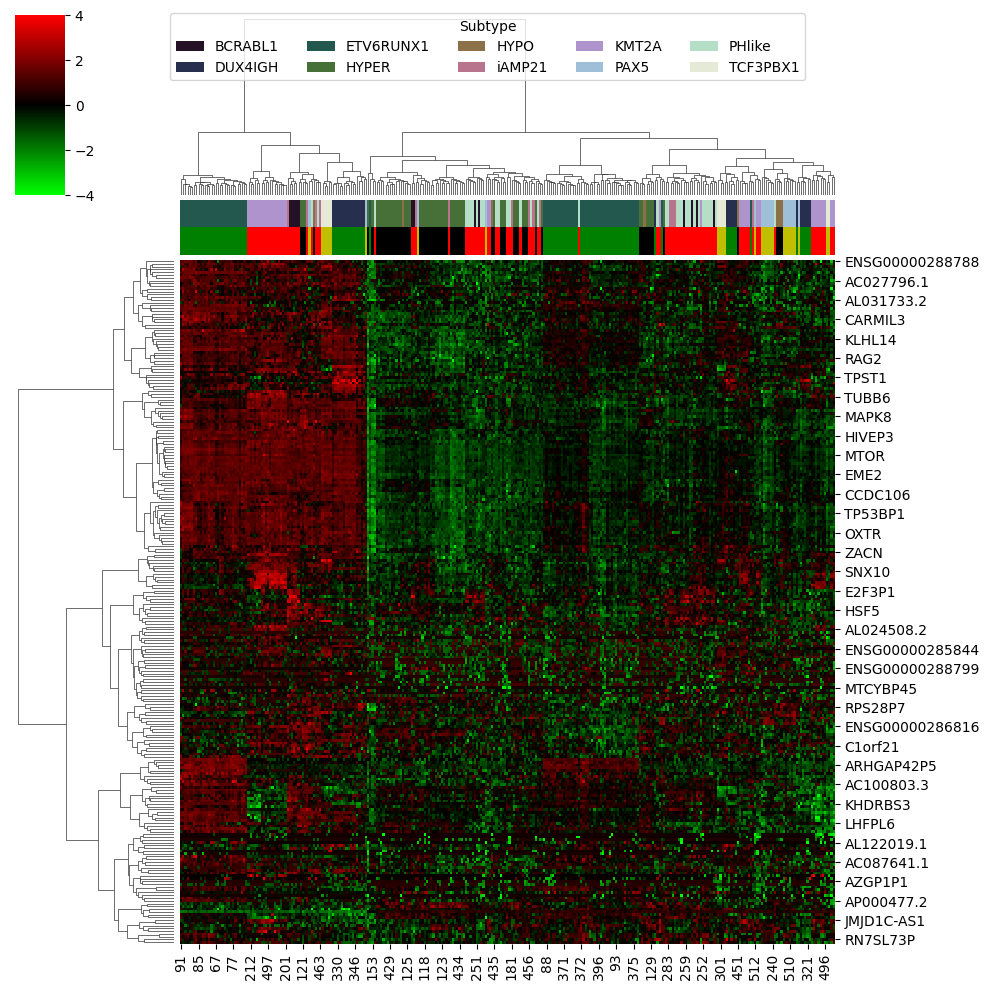

In [29]:
cluster_data = white_people_data.drop(axis=1, labels=["prognostic", "subtype"])[important_genes].transpose()

subtypes = white_people_data["subtype"]
palette = sns.cubehelix_palette(subtypes.unique().size, light=.9, dark=.1, reverse=True, start=1, rot=-2)
lut = dict(zip(map(str, subtypes.unique()), palette))
col_colors = [subtypes.map(lut), white_people_data["prognostic"].map({ "POOR": "r", "GOOD": "g", "MODERATE": "y", "UNKNOWN": "black" })]

g = plot_clustermap(cluster_data, col_colors)
plot_legend(g, subtypes, lut)

plt.show()

In [30]:
# one_vs_all_search_params = {"n_estimators": (128, 256, 512), "max_depth": (64, 128, 256, None), "class_weight": ("balanced", None), "max_features": (None, "sqrt", "log2")}
# one_vs_all_response = train_forest(target="subtype", data=data[["prognostic", "subtype", *important_genes]], grid_search_params=one_vs_all_search_params)
one_vs_all_response = train_forest(target="subtype", data=white_people_data[["prognostic", "subtype", *important_genes]], n_estimators=512, class_weight=None, max_depth=64, max_features=None)
print(one_vs_all_response.model.get_params())
print(f"F1 Score: {one_vs_all_response.f1}, Acc: {one_vs_all_response.acc}")

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 64, 'max_features': None, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 512, 'n_jobs': -1, 'oob_score': False, 'random_state': 774, 'verbose': 0, 'warm_start': False}
F1 Score: 0.8189361084301608, Acc: 0.7001587301587302


/Users/igormandello/projects/lla-analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/igormandello/projects/lla-analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/igormandello/projects/lla-analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [75]:
# one_vs_all_search_params = {"learning_rate": (0.05, 0.1, 1), "max_features": (0.05, 0.1, 0.15, 0.2, 0.5,), "min_samples_leaf": (5, 10, 15, 20), "l2_regularization": (0, 0.5, 1)}
# one_vs_all_response = train_gradient_boosting(target="subtype", data=white_people_data[["prognostic", "subtype", *important_genes]], grid_search_params=one_vs_all_search_params, max_depth=32)
# print(one_vs_all_response.model.get_params())

parameters = {
    "target": "subtype",
    "data": white_people_data[["prognostic", "subtype", *important_genes]],
    "learning_rate": 0.1,
    "max_features": 0.15,
    "min_samples_leaf": 15,
    "max_depth": 32
}

one_vs_all_response = train_gradient_boosting(**parameters)
print(f"F1 Score: {one_vs_all_response.f1}, Acc: {one_vs_all_response.acc}")
print(one_vs_all_response.test_report)

black_X = one_vs_all_response.scaler.transform(black_people_data[important_genes])
print(f"Black people F1: {f1_score(black_people_data["subtype"], one_vs_all_response.model.predict(black_X), average="weighted")}")

white_f1s = []
black_f1s = []
for seed in random.random_integers(low=0, high=2**32 - 1, size=100):
    random.mtrand._rand.seed(seed)
    one_vs_all_response = train_gradient_boosting(**parameters)
    white_f1s.append(one_vs_all_response.f1)
    
    black_X = one_vs_all_response.scaler.transform(black_people_data[important_genes])
    black_f1s.append(f1_score(black_people_data["subtype"], one_vs_all_response.model.predict(black_X), average="weighted"))

print(f"White people F1: {np.mean(white_f1s):.4f} ± {np.std(white_f1s):.4f}")
print(f"Black people F1: {np.mean(black_f1s):.4f} ± {np.std(black_f1s):.4f}")

F1 Score: 0.8247339281598692, Acc: 0.7280701754385965
              precision    recall  f1-score   support

     BCRABL1       0.00      0.00      0.00         3
     DUX4IGH       0.88      1.00      0.93         7
   ETV6RUNX1       1.00      0.95      0.97        19
       HYPER       0.71      1.00      0.83        15
        HYPO       1.00      0.50      0.67         2
       KMT2A       1.00      0.90      0.95        10
        PAX5       0.60      0.60      0.60         5
      PHlike       0.75      0.67      0.71         9
    TCF3PBX1       1.00      1.00      1.00         3
      iAMP21       0.67      0.67      0.67         3

    accuracy                           0.84        76
   macro avg       0.76      0.73      0.73        76
weighted avg       0.82      0.84      0.82        76

Black people F1: 0.9176808905380334
White people F1: 0.8682 ± 0.0324
Black people F1: 0.9048 ± 0.0193


In [78]:
white_people_data["subtype"].value_counts()

subtype
ETV6RUNX1    77
HYPER        59
KMT2A        38
PHlike       36
DUX4IGH      27
PAX5         18
iAMP21       14
BCRABL1      13
TCF3PBX1     11
HYPO          8
Name: count, dtype: int64